In [1]:
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from keras.models import load_model
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import ImageFile
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


Using TensorFlow backend.


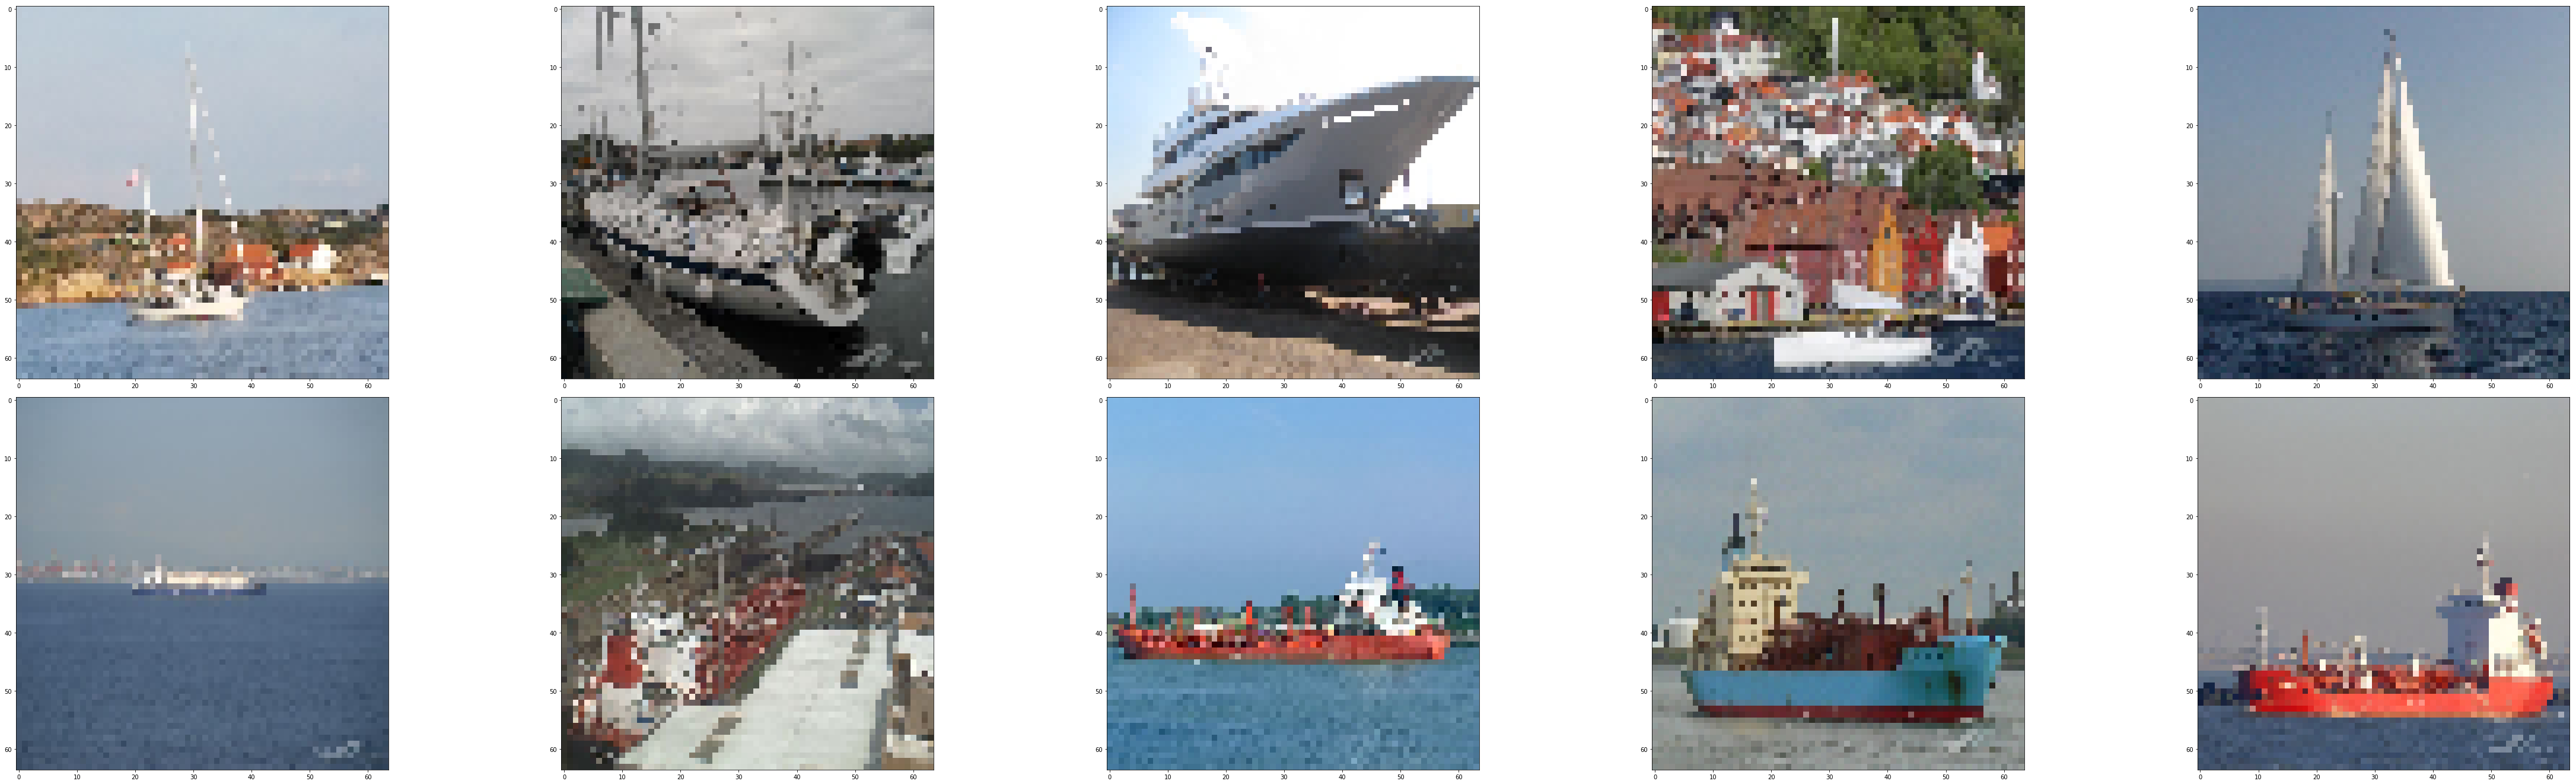

In [2]:
# size of the image: 48*48 pixels
pic_size = 64

# input path for the images
base_path = "/home/jose/Masaüstü/ship_dataset_6500_1625_yacht_tanker/"

plt.figure(0, figsize=(pic_size,pic_size))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [3]:
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " ship_dataset")

6500 yacht ship_dataset
6500 tanker ship_dataset


In [4]:
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 256
# number of epochs to train the NN
epochs = 2
#max plot test sample
num_of_test_samples = 3250

datagen_train = ImageDataGenerator( rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

datagen_validation = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 13000 images belonging to 2 classes.
Found 3250 images belonging to 2 classes.


In [5]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 2

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(pic_size, pic_size,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:


from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("thesis_model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1625/1625 [==============================] - 784s 482ms/step - loss: 0.5020 - acc: 0.7681 - val_loss: 0.3360 - val_acc: 0.8565

Epoch 00001: val_acc improved from -inf to 0.85653, saving model to thesis_model_weights.h5


In [ ]:
model_json = model.to_json()
with open("thesis_model.json", "w") as json_file:
    json_file.write(model_json)

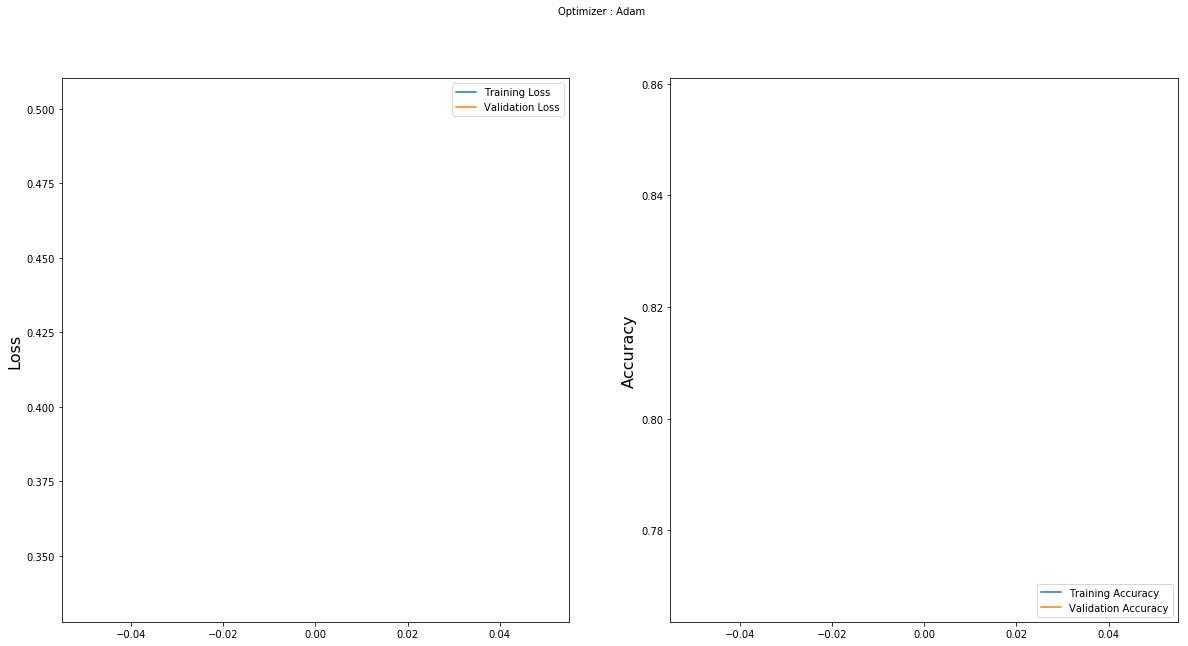

In [7]:

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [8]:
#filenames = validation_generator.filenames
#nb_samples = len(filenames)
#predictions = model.predict_generator(generator=validation_generator, steps = nb_samples)



predictions = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()
print(class_names)




['tanker', 'yacht']


<Figure size 432x288 with 0 Axes>

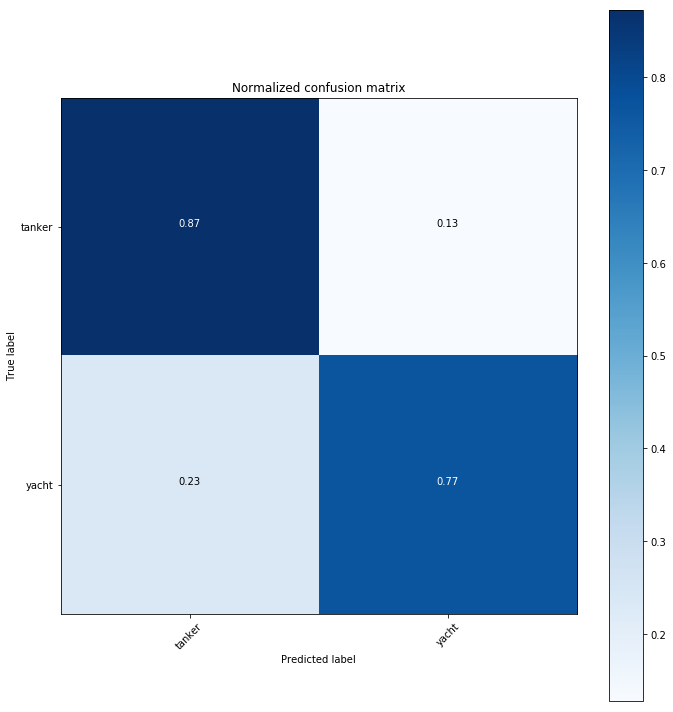

In [9]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [ ]:
model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png')

In [ ]:
plot_model(model, to_file='multilayer_perceptron_graph.png')

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


SVG(model_to_dot(model).create(prog='dot', format='svg'))

#TESTING START

In [23]:
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return  listOfKeys

In [24]:
import cv2
import operator

predict_image_path = '/home/jose/Masaüstü/tanker.jpeg'

img = cv2.imread(predict_image_path)
img = np.random.randint(0,10,(pic_size,pic_size,1))
img.shape
img = np.expand_dims(img, axis=0)
img.shape

predict = model.predict(img)
predicted_class_indices = {'tanker': 1, 'yacht': 0}
print(predicted_class_indices)
print(predict)

index, value = max(enumerate(predict), key=operator.itemgetter(1))
print(max(value))

max_predict = predict.argmax(axis=1)[0]
print(max_predict)



print(getKeysByValue(predicted_class_indices, max_predict)[0])

{'tanker': 1, 'yacht': 0}
[[  1.11e-17   1.00e+00]]
1.0
1
tanker


In [ ]:
import cv2
orig = cv2.imread(predict_image_path)
cv2.putText(orig, "Predicted: {}({:.2f})%".format(getKeysByValue(predicted_class_indices, max_predict)[0], max(value) *100), (10, 30),
                cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)

cv2.imshow("Classification", orig)
cv2.waitKey(10000)
cv2.destroyAllWindows()